In [1]:
import os
import time

import multiprocessing as mp

import tsp_proc as tsp

print("Ok!")

Ok!


In [2]:
'''
## TSP
MLPC, 13 towns, 14 procs: Ok! Total count: 239,500,800. Time taken: 106.48 sec.
MLPC, 14 towns, 14 procs: Ok! Total count: 3,113,510,400. Time taken: 1339.78 sec.
MLPC, 15 towns, 22 procs: Ok! Total count: 43,589,145,600. Time taken: 17702.65 sec.

HSCH, 13 towns, 10 procs: Ok! Total count: 239,500,800. Time taken: 149.67 sec.
HSCH, 13 towns, 14 procs: Ok! Total count: 239,500,800. Time taken: 121.86 sec.
HSCH, 14 towns, 14 procs: Ok! Total count: 3,113,510,400. Time taken: 1692.29 sec.

XTST, 12 towns, 3 procs:  Ok! Total count: 19,958,400. Time taken: 21.83 sec.  
XTST, 12 towns, 6 procs:  Ok! Total count: 19,958,400. Time taken: 16.32 sec.  
XTST, 13 towns, 6 procs:  Ok! Total count: 239,500,800. Time taken: 203.89 sec.
XTST, 13 towns, 10 procs: Ok! Total count: 239,500,800. Time taken: 166.46 sec.

ISGM, 12 towns, 6 procs:  Ok! Total count: 19,958,400. Time taken: 15.12 sec.
ISGM, 13 towns, 6 procs:  Ok! Total count: 239500800. Time taken: 220.58 sec.

CAVL, 12 towns, 6 procs:  Ok! Total count: 19,958,400. Time taken: 21.75 sec.
CAVL, 13 towns, 6 procs:  Ok! Total count: 239,500,800. Time taken: 276.33 sec.
CAVL, 14 towns, 6 procs:  Ok! Total count: 3,113,510,400. Time taken: 3838.15 sec.

ISEM, 12 towns, 3 procs, Ok! Total count: 239500800. Time taken: 34.95 sec.
ISEM, 12 towns, 6 procs, Ok! Total count: 239500800. Time taken: 28.38 sec.
ISEM, 13 towns, 6 procs, Ok! Total count: 239500800. Time taken: 350.47 sec.

AHFM, 12 towns, 3 procs:  Ok! Total count: 19,958,400. Time taken: 67.81 sec.
AHFM, 13 towns, 3 procs:  Ok! Total count: 239,500,800. Time taken: 869.20 sec.

## MACHINES DESCRIPTION
MLPC - clustech office PC: Ubuntu - CPU 24 threads + GPU 2080Ti
HSCH - Hugo-Schmeisser PC: WSL - CPU 16 threads + GPU 2070S
AHFM - Albert-Hofmann PC: WSL - CPU 4 threads + GPU `forget about it`
ISGM - ISGN machine: Ubuntu - CPU 8 threads + GPU Intel Xe
CAVL - Henry-Cavill PC: Ubuntu - CPU 8 threads + GPU Vega6(7?)
XTST - Xitst PC: WSL - CPU 12 threads + GPU Intel Xe
ISEM - Siemens KZ PC: WSL - CPU 8 threads + GPU Intel Xe
'''

## INPUTS
numTowns = 13
headSize = 2
numWorkers = 6

print("Ok!")

Ok!


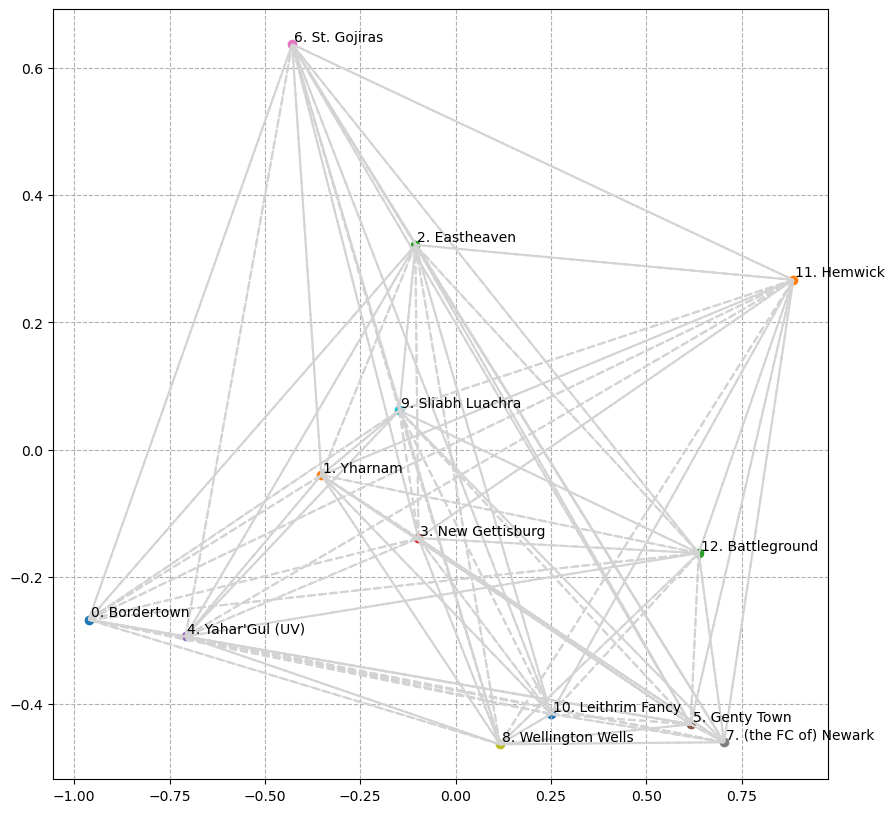

In [3]:
idlessTowns = tsp.generateTowns(n=numTowns)
townIds = list(range(len(idlessTowns)))
xs = [t[1][0] for t in idlessTowns]
ys = [t[1][1] for t in idlessTowns]

towns = [(i,)+town for i,town in zip(townIds, idlessTowns)]
tsp.plotTowns(idlessTowns)

In [4]:
timeStart = time.time()

numRoutes = tsp.phuc(len(townIds)-1) // 2
print("HST: Expected usefull routes count: {}".format(numRoutes))

heads = tsp.headsFn(townIds, headSize=headSize)
heads = tsp.startEndShuffle(heads)
batches = tsp.batchList(heads, numBatches=numWorkers)

distMatrix = tsp.xyDistMatrix(xs, ys)

print("HST: creating workers")
quesToCnt = [mp.Queue() for _ in range(numWorkers)]
queToHost = mp.Queue()

workers = [mp.Process(target=tsp.cntWorkerFn(no, townIds, distMatrix, name="countFn_{}".format(no)),
                      args=(queToCnt, queToHost)) \
           for no,queToCnt in enumerate(quesToCnt)]

for worker in workers:
    worker.start()
    
for queToCnt,batch in zip(quesToCnt, batches):
    queToCnt.put(tsp.LoadMsg(load=batch))
    
numRunningWorkers = numWorkers
candidates = []
currentRoutesCount = 0
running = True
while running:
    msg = queToHost.get()
    
    if isinstance(msg, tsp.PoisonMsg):
        numRunningWorkers -= 1
        if numRunningWorkers < 1:
            running = False
            
    elif isinstance(msg, tsp.InfoMsg):
        info = msg.info
        if isinstance(info, dict):
            if info["summary"] == "Routes Count Report":
                currentRoutesCount += info["count"]
                print("HST: Current routes count: {} / {}".format(currentRoutesCount, numRoutes))
                
            elif info["summary"] == "Something Else":
                pass
            
            else:
                print("HST: Strange info message recieved")
        
        else:
            print(info)
        
    elif isinstance(msg, tsp.LoadMsg):
        candidates += [msg.load]
        
    else:
        print("HST: recieved a message of unknown purpose")
        
for queToCnt in quesToCnt:
    queToCnt.put(tsp.PoisonMsg())
    
for worker in workers:
    worker.join()
    
for que in quesToCnt:
    que.close()
        
minRoute = None
minDistance = 999.0
totalCount = 0
for c in candidates:
    if c[1] < minDistance:
        minRoute = c[0]
        minDistance = c[1]
    totalCount += c[2]
        
print("{} ==> {}".format(minRoute, minDistance))

timeTaken = time.time() - timeStart
print("Ok! Total count: {}. Time taken: {} sec.".format(totalCount, "%.2f"%timeTaken))

HST: Expected usefull routes count: 239500800
HST: creating workers
CNT0: starting...
CNT1: starting...
CNT2: starting...
CNT3: starting...
CNT4: starting...
CNT5: starting...
CNT0: heads recieved: (1, 2)...
CNT1: heads recieved: (11, 1)...
CNT2: heads recieved: (10, 2)...
CNT3: heads recieved: (9, 3)...
CNT4: heads recieved: (8, 4)...
CNT5: heads recieved: (7, 5)...
HST: Current routes count: 362880 / 239500800
HST: Current routes count: 1088640 / 239500800
HST: Current routes count: 2177280 / 239500800
HST: Current routes count: 3628800 / 239500800
HST: Current routes count: 5443200 / 239500800
HST: Current routes count: 9072000 / 239500800
HST: Current routes count: 9072000 / 239500800
HST: Current routes count: 12337920 / 239500800
HST: Current routes count: 15240960 / 239500800
HST: Current routes count: 18869760 / 239500800
HST: Current routes count: 21047040 / 239500800
HST: Current routes count: 23587200 / 239500800
HST: Current routes count: 23950080 / 239500800
HST: Current r

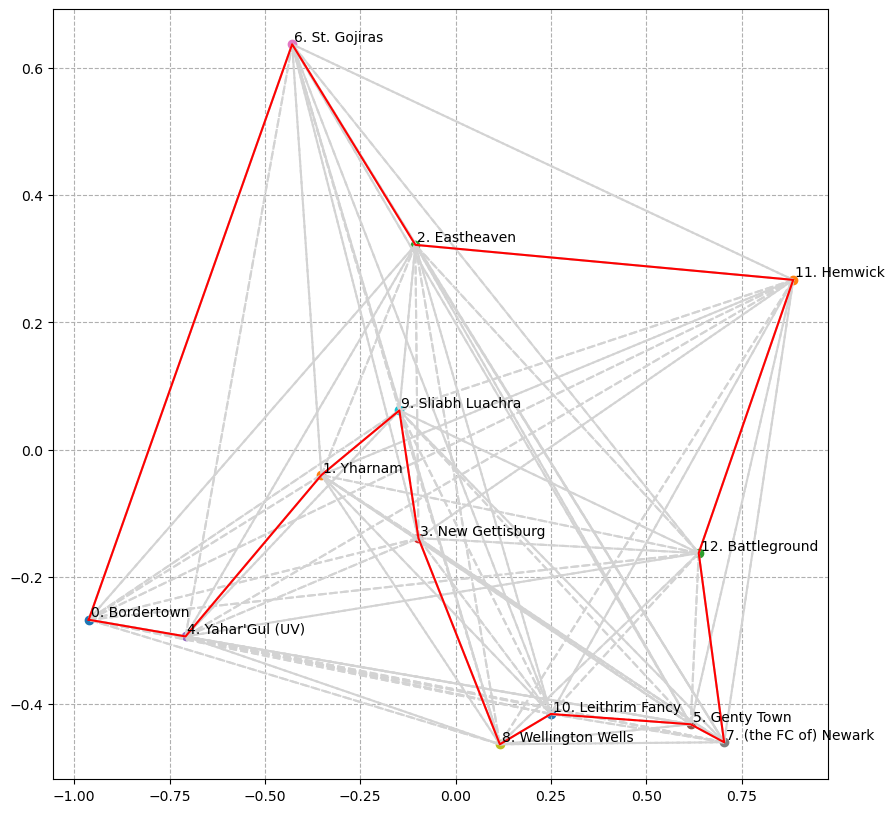

In [5]:
targetRoute = [idlessTowns[i] for i in minRoute]
tsp.plotTowns(idlessTowns, shortestTravel=targetRoute, plotSize=10)